In [ ]:
!pip install -q transformers datasets torchvision evaluate accelerate torch pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
from PIL import Image
import numpy as np
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import evaluate
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/datasets/Waste_data'



Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


checks Images counts and sanity


Fashion -> 197 images
Glass -> 501 images
Metal -> 410 images
Organic -> 197 images
Paper -> 594 images
Plastic -> 482 images


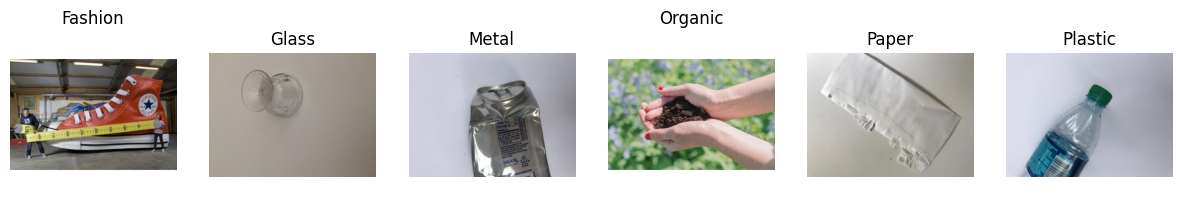

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

root = "/content/drive/MyDrive/Waste_data"

for label in sorted(os.listdir(root)):
    path = os.path.join(root, label)
    if os.path.isdir(path):
        print(label, "->", len(os.listdir(path)), "images")

# Show a grid of sample images from each class
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
labels = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

for i, lbl in enumerate(labels[:6]):
    imgpath = os.path.join(root, lbl, os.listdir(os.path.join(root, lbl))[0])
    img = Image.open(imgpath).convert("RGB")
    axs[i].imshow(img)
    axs[i].set_title(lbl)
    axs[i].axis('off')

plt.show()


hugging face datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Waste_data")
dataset


Resolving data files:   0%|          | 0/2381 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2381
    })
})

In [ ]:
from datasets import DatasetDict

# 80% train, 20% validation
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    "train": dataset["train"],
    "validation": dataset["test"]
})

dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1904
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 477
    })
})

using a pretrained model from huggingface (watersplash waste classification)

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer

model_name = "watersplash/waste-classification"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

model.config.num_labels = 6
model.classifier = torch.nn.Linear(model.classifier.in_features, 6)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Preprocessing trasnsforms

In [ ]:
from transformers import AutoImageProcessor


model_name = "watersplash/waste-classification"
processor = AutoImageProcessor.from_pretrained(model_name)


def transform(example_batch):
    # Apply the processor to all images in a batch
    inputs = processor(images=example_batch["image"], return_tensors="pt")
    inputs["labels"] = example_batch["label"]
    return inputs

prepared_ds = dataset.with_transform(transform)


Creating the model object for fine tuning

In [ ]:
from transformers import AutoModelForImageClassification

labels = ["plastic", "paper", "glass", "fashion", "metal", "organic"]
num_labels = len(labels)

checkpoint = "watersplash/waste-classification"

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
    id2label={i: label for i, label in enumerate(labels)},
    label2id={label: i for i, label in enumerate(labels)}
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at watersplash/waste-classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([12]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([12, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training arguments

In [ ]:
import evaluate
import numpy as np

# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


Traing arguments

In [ ]:
from transformers import TrainingArguments
import torch

training_args = TrainingArguments(
    output_dir="./waste_classification_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    learning_rate=3e-5,
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)


Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    compute_metrics=compute_metrics
)


Trained model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Saving the model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

# Load model and processor
model_path = "/content/drive/MyDrive"
model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)

model.eval()  # set to evaluation mode


In [ ]:
model.config.id2label = {
    0: "fashion",
    1: "glass",
    2: "metal",
    3: "organic",
    4: "paper",
    5: "plastic"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}


In [ ]:
model.save_pretrained("./waste_model")
processor.save_pretrained("./waste_model")


In [ ]:
img_path = "/content/drive/MyDrive/Waste_data/Metal/metal56.jpg"
img = Image.open(img_path).convert("RGB")

inputs = processor(images=img, return_tensors="pt").to(model.device)
outputs = model(**inputs)
pred_class = outputs.logits.argmax(-1).item()

print("Predicted label:", model.config.id2label[pred_class])


In [ ]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Plastic_bottle.jpg/640px-Plastic_bottle.jpg"


response = requests.get(url)
response.raise_for_status()


img = Image.open(BytesIO(response.content)).convert("RGB")
display(img)


inputs = processor(images=img, return_tensors="pt").to(model.device)
outputs = model(**inputs)
pred_class = outputs.logits.argmax(-1).item()

print("Predicted label:", model.config.id2label[pred_class])


